# **Lab 2: Brain Tumor MRI Feature Extraction**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [4]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import torch
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

## **1: Business & Data Understanding**

## **2: Data Preparation**

In [3]:
# Load Train / Test Data
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

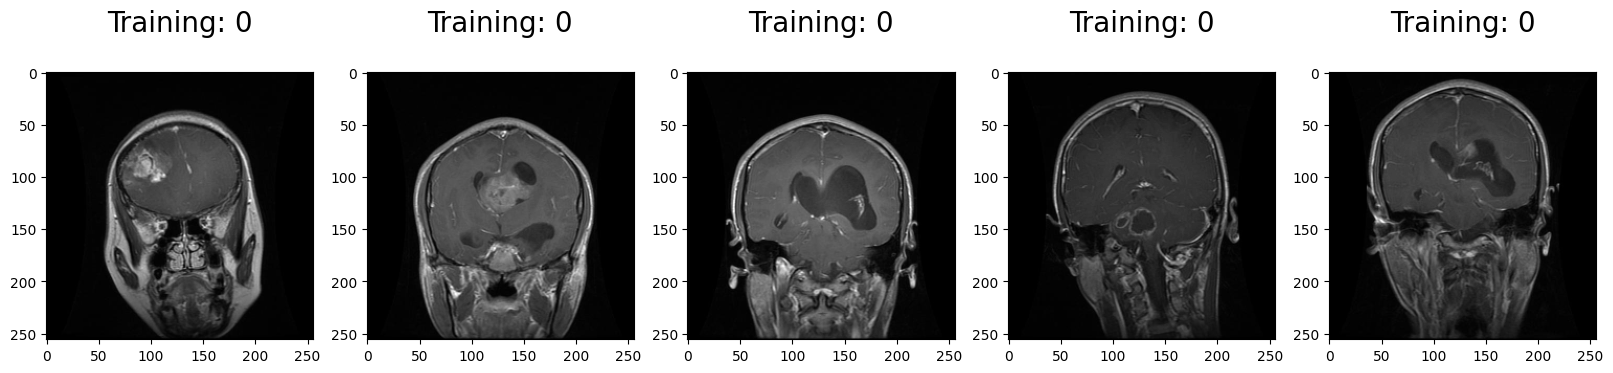

In [4]:
# Display Some Images From trainPaths
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(trainPaths[0:5], trainLabels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)
plt.show()

## **3: Data Reduction**

### **3.1: Dimensionality Reduction with Principal Component Analysis**

### **3.2: Dimensionality with Randomized Principal Component Analysis**

### **3.3: Compare PCA and Randomized PCA**

### **3.4: Feature Extraction using ResNet**

For feature extraction, we decided to use a PyTorch implementation of the <a href="https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet">Residual Network (ResNet)</a> architecture.  

In [5]:
# Instantiate the ResNet50 model
resnet50: models.ResNet = models.resnet50(pretrained = True)

cuda:0


In [6]:
%%time
# 1. Prepare the ResNet50 model for transfer learning
# 
# This replaces the last fully connected layer (originally trained for 
# the 1000-class ImageNet dataset) with a new fully connected layer that matches the 
# number of classes in your MRI dataset. Since this layer is newly initialized, it 
# contains random weights and will be trained from scratch, while the other layers 
# contain pre-trained weights from ImageNet.
NUM_CLASSES: int = len(labels)
resnet50.fc: torch.nn.Module = (
    torch.nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Send the model to the selected device 

# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 32
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, # No need to shuffle test data
    )
)

# 3. Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop (THIS LOOP WAS GENERATED BY CHATGPT)
NUM_EPOCHS: int = 10
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set the model to training mode
    train_loss: float = 0.0  # Initialize training loss
    
    # For each batch of images and labels
    for images, labels in train_loader:
        images: Tensor = images.to(device)  # Send data to the device (GPU/CPU)
        labels: Tensor = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs: Tensor = resnet50(images)  # Forward pass: Get model predictions
        loss: Tensor = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

    # Print average training loss for this epoch        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training loss: {train_loss/len(train_loader)}")

# 4. Evaluate the model
resnet50.eval()  # Set the model to evaluation mode
correct: int = 0  # Count of correct predictions
total: int = 0   # Total number of images processed

# We won't update the model, so we tell PyTorch not to compute gradients
with torch.no_grad():
    for images, labels in test_loader:
        images: Tensor = images.to(device)
        labels: Tensor = labels.to(device)
        outputs: Tensor = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Print the accuracy of the model on the test data
print(f"Accuracy of the model on test images: {100 * correct / total}%")

cuda:0
Epoch 1/10 - Training loss: 0.4171058736616673
Epoch 2/10 - Training loss: 0.24048794202464918
Epoch 3/10 - Training loss: 0.17606037150673026
Epoch 4/10 - Training loss: 0.1445209681974755
Epoch 5/10 - Training loss: 0.11966687487308249
Epoch 6/10 - Training loss: 0.10562789063203518
Epoch 7/10 - Training loss: 0.0759450301941609
Epoch 8/10 - Training loss: 0.07359373944358868
Epoch 9/10 - Training loss: 0.07474656748408504
Epoch 10/10 - Training loss: 0.07426049515563349
Accuracy of the model on test images: 96.5675057208238%
CPU times: total: 37min 19s
Wall time: 10min 44s


### **3.5: ResNET Performance for Prediction Task**

## **4: Exceptional Work**

In the script below, we show off dense matching,

In [25]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

In [1]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os
import math
import itertools
from functools import partial
from tqdm.notebook import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import mmcv
from mmengine.runner import load_checkpoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import torch.backends.cudnn as cudnn
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
import urllib
import time
import copy
import random
import json
import requests
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

# DinoV2 Imports (Includes OpenMMLabs)
from dinov2.eval.depth.models import build_depther

In [4]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "giant" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)
backbone_model.eval()
backbone_model.cuda()

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [5]:
# Reload Information (Same As Before)

# Load Train / Test Data (Set IMG_SIZE = 256, Can Be <= 512)
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding (0, 1, 2, 3)
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # train_paths: List Of Numpy Arrays Specifying Training Data
train_labels: List[int] = []        # train_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)
test_paths: List[np.ndarray] = []   # test_paths: List Of Numpy Arrays Specifying Testing Data
test_labels: List[int] = []         # test_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0)

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0) 

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

In [6]:

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])


transform1 = transforms.Compose([           
                                transforms.Resize(512),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [7]:
patch_size = backbone_model.patch_size # patchsize=14

#520//14
patch_h  = 520 // patch_size
patch_w  = 520 // patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

total_features  = []
with torch.no_grad():
    for label in labels:
        for img_file in glob.glob('Dataset/Training/' + f'/{label}/*.jpg'):

            # Open Image File, Convert To RGB
            img = Image.open(img_file).convert('RGB')

            # Transform (Keeping Data Same), Force Data Onto Same Device
            img_t = transform1(img).to(device)

            # Forward Pass (Get Features)
            features_dict = backbone_model.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)

            break

total_features = torch.cat(total_features, dim = 0)
total_features.shape

torch.Size([4, 1369, 1536])

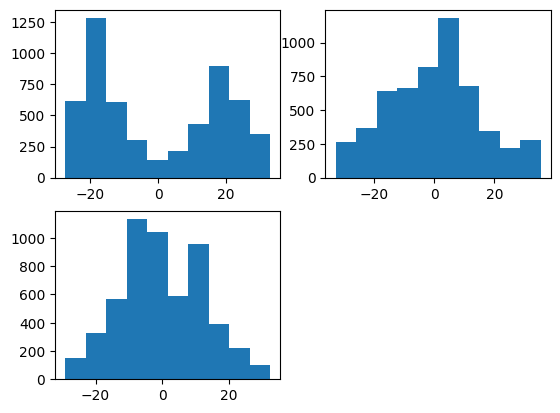

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
# Copy the CUDA tensor to CPU memory
cpu_tensor = total_features.cpu()

# Convert the CPU tensor to a NumPy array
numpy_array = cpu_tensor.numpy()

pca.fit(numpy_array)
pca_features = pca.transform(numpy_array)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

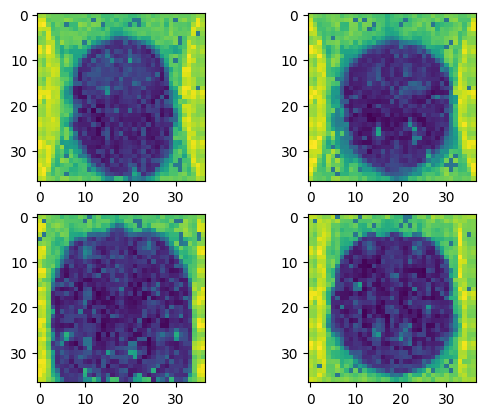

In [9]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

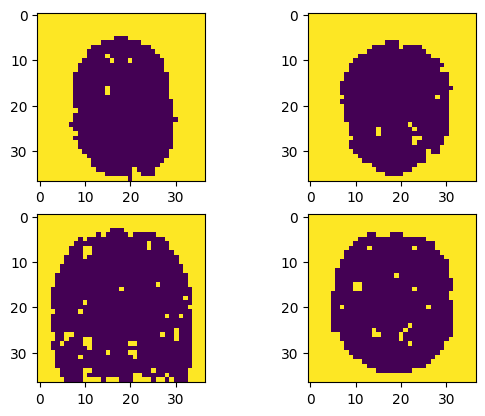

In [10]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

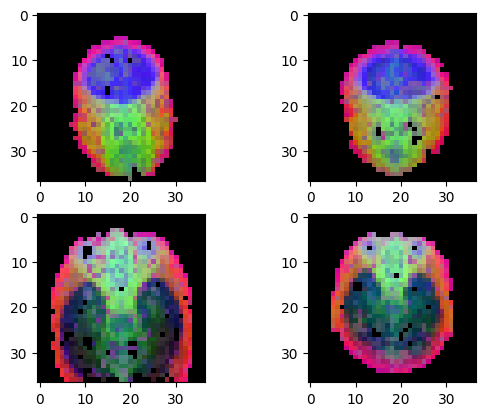

In [11]:
# 2nd PCA for only foreground patches
pca.fit(numpy_array[pca_features_fg]) 
pca_features_left = pca.transform(numpy_array[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [12]:
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = functional.pad(x, pads)
        return output

def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther


In [13]:
def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

Loads checkpoint by http backend from path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_nyu_dpt_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1536, 192, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1536, 384, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1536, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

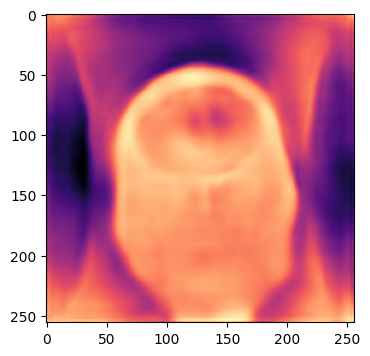

In [16]:
def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Repeat the single channel to make it 3-channel
        lambda x: 255.0 * x, # scale by 255 
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

transform = make_depth_transform()

transformed_image = transform(np.reshape(trainPaths[0], (IMG_SIZE, IMG_SIZE)).astype(np.float32))
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
plt.figure(figsize = (20, 4))
plt.imshow(depth_image)
plt.show()

In [17]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

In [25]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os
import math
import itertools
from functools import partial
from tqdm.notebook import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import mmcv
from mmengine.runner import load_checkpoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import torch.backends.cudnn as cudnn
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
import urllib
import time
import copy
import random
import json
import requests
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

In [27]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "small" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main


In [28]:
def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset/'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = 6, 
                                              shuffle = True,
                                              num_workers = 4) 
                                              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

In [30]:
# 384 For Small, 768 For Base, 1024 For Large, 1536 For Giant
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = backbone_model
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)        
        return x

In [23]:
model = DinoVisionTransformerClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.000001)

In [31]:
NUM_EPOCHS: int = 2
for epoch in range(NUM_EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(dataloaders["Training"], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: nan
[1,   100] loss: nan
[1,   150] loss: nan
[1,   200] loss: nan
[1,   250] loss: nan
[1,   300] loss: nan
[1,   350] loss: nan
[1,   400] loss: nan
[1,   450] loss: nan
[1,   500] loss: nan
[1,   550] loss: nan
[1,   600] loss: nan
[1,   650] loss: nan
[1,   700] loss: nan
[1,   750] loss: nan
[1,   800] loss: nan
[1,   850] loss: nan
[1,   900] loss: nan
[1,   950] loss: nan
[2,    50] loss: nan
[2,   100] loss: nan
[2,   150] loss: nan
[2,   200] loss: nan
[2,   250] loss: nan
[2,   300] loss: nan
[2,   350] loss: nan
[2,   400] loss: nan
[2,   450] loss: nan
[2,   500] loss: nan
[2,   550] loss: nan
[2,   600] loss: nan
[2,   650] loss: nan
[2,   700] loss: nan
[2,   750] loss: nan
[2,   800] loss: nan
[2,   850] loss: nan
[2,   900] loss: nan
[2,   950] loss: nan
Finished Training


In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["Testing"]:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

print(f'Accuracy of the network on the {len(dataloaders["Testing"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 1314 test images: 22 %
